In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
import warnings
warnings.filterwarnings("ignore")
from glob import glob
import re
import gc
from scipy.stats import zscore
from sklearn.covariance import EllipticEnvelope
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [4]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV,GridSearchCV,cross_validate

# 1- Data Collection

In [5]:
!wget "https://archive.ics.uci.edu/ml/machine-learning-databases/00287/Activity%20Recognition%20from%20Single%20Chest-Mounted%20Accelerometer.zip"

--2021-01-10 12:35:06--  https://archive.ics.uci.edu/ml/machine-learning-databases/00287/Activity%20Recognition%20from%20Single%20Chest-Mounted%20Accelerometer.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 11256835 (11M) [application/x-httpd-php]
Saving to: ‘Activity Recognition from Single Chest-Mounted Accelerometer.zip’

Activity Recognitio 100%[===================>]  10.74M  --.-KB/s    in 0.1s    

2021-01-10 12:35:06 (72.6 MB/s) - ‘Activity Recognition from Single Chest-Mounted Accelerometer.zip’ saved [11256835/11256835]



In [6]:
!unzip "/content/Activity Recognition from Single Chest-Mounted Accelerometer.zip"

Archive:  /content/Activity Recognition from Single Chest-Mounted Accelerometer.zip
   creating: Activity Recognition from Single Chest-Mounted Accelerometer/
  inflating: Activity Recognition from Single Chest-Mounted Accelerometer/.DS_Store  
   creating: __MACOSX/
   creating: __MACOSX/Activity Recognition from Single Chest-Mounted Accelerometer/
  inflating: __MACOSX/Activity Recognition from Single Chest-Mounted Accelerometer/._.DS_Store  
  inflating: Activity Recognition from Single Chest-Mounted Accelerometer/1.csv  
  inflating: Activity Recognition from Single Chest-Mounted Accelerometer/10.csv  
  inflating: Activity Recognition from Single Chest-Mounted Accelerometer/11.csv  
  inflating: Activity Recognition from Single Chest-Mounted Accelerometer/12.csv  
  inflating: Activity Recognition from Single Chest-Mounted Accelerometer/13.csv  
  inflating: Activity Recognition from Single Chest-Mounted Accelerometer/14.csv  
  inflating: Activity Recognition from Single Chest-Mo

# 2- Data Preperation

Goal: The activities are predicted based the movements traced by the accelerometer for 15 users. Every participant wore a custom-developed chest mounted uncaliberated acceleraometer and the data was collected at 52 observations per second. The 7 activities in the Label column of the data is explored against the acceleration in x,y and z-axis.

In [7]:
files_path=glob(r"/content/Activity Recognition from Single Chest-Mounted Accelerometer/*.csv")

In [8]:
def Dataframe(files_path):
    df_participants=pd.DataFrame()
    for index,file_path in enumerate(files_path):
        df=pd.read_csv(file_path,header=None)
        df["User_id"]=int(re.sub(r'[^0-9]',"",file_path))
        df_participants=df_participants.append(df.iloc[:,1:])
    return df_participants

In [9]:
data=Dataframe(files_path)
data.columns=['x_acceleration','y_acceleration','z_acceleration','Label','User_id']
data.index=range(len(data))

In [10]:
data=data.reindex(columns=["User_id","x_acceleration","y_acceleration","z_acceleration","Label"])

In [11]:
data

,User_id,x_acceleration,y_acceleration,z_acceleration,Label
0,12,1922,2388,1898,1
1,12,1880,2327,1832,1
2,12,1847,2281,1842,1
3,12,1859,2330,1869,1
4,12,1931,2306,1853,1
...,...,...,...,...,...
1926891,1,1927,2388,2074,7
1926892,1,1930,2383,2074,7
1926893,1,1929,2385,2076,7
1926894,1,1926,2385,2078,7


In [12]:
data.shape

(1926896, 5)

In [13]:
# Counts of each participants
data.User_id.value_counts().sort_index()

1     162501
2     138001
3     102341
4     122201
5     160001
6     140901
7     163001
8     138001
9     166741
10    126801
11    104451
12    114702
13     67651
14    116101
15    103501
Name: User_id, dtype: int64

In [14]:
# Checking Null values 
data.isnull().sum()
## There are no Null values

User_id           0
x_acceleration    0
y_acceleration    0
z_acceleration    0
Label             0
dtype: int64

In [15]:
# Checking some statistical values
data.describe()

,User_id,x_acceleration,y_acceleration,z_acceleration,Label
count,1.926896e+06,1.926896e+06,1.926896e+06,1.926896e+06,1.926896e+06
mean,7.512711e+00,1.987652e+03,2.382523e+03,1.970596e+03,3.882898e+00
std,4.172396e+00,1.113578e+02,1.003151e+02,9.445893e+01,2.443402e+00
min,1.000000e+00,2.820000e+02,2.000000e+00,1.000000e+00,0.000000e+00
25%,4.000000e+00,1.904000e+03,2.337000e+03,1.918000e+03,1.000000e+00
50%,7.000000e+00,1.992000e+03,2.367000e+03,1.988000e+03,4.000000e+00
75%,1.100000e+01,2.076000e+03,2.413000e+03,2.032000e+03,7.000000e+00
max,1.500000e+01,3.828000e+03,4.095000e+03,4.095000e+03,7.000000e+00


In [16]:
# Target incidence
data.Label.value_counts().sort_index()

0      3719
1    608667
2     47878
3    216737
4    357064
5     51498
6     47770
7    593563
Name: Label, dtype: int64

In [17]:
# Here rows having '0' as Label will be dropped
data.drop(list(data[data.Label==0].index),axis=0,inplace=True)

In [18]:
data.set_axis(range(len(data)),axis=0,inplace=True)

In [19]:
# adding more features to the data
A_x=np.square(data['x_acceleration'])
A_y=np.square(data['y_acceleration'])
A_z=np.square(data['z_acceleration'])
A_m=np.sqrt(A_x + A_y + A_z)
data["mag_acceleration"]=A_m
data=data.reindex(["User_id","x_acceleration","y_acceleration","z_acceleration","mag_acceleration","Label"],axis=1)

In [20]:
data.head()

,User_id,x_acceleration,y_acceleration,z_acceleration,mag_acceleration,Label
0,12,1922,2388,1898,3605.417036,1
1,12,1880,2327,1832,3507.927166,1
2,12,1847,2281,1842,3465.160025,1
3,12,1859,2330,1869,3518.229953,1
4,12,1931,2306,1853,3532.705196,1


# 3- EDA

In [21]:
# Corelation of features with the target variable
data.corr().Label.sort_values()

User_id            -0.168296
z_acceleration      0.035025
y_acceleration      0.048724
mag_acceleration    0.074253
x_acceleration      0.077737
Label               1.000000
Name: Label, dtype: float64

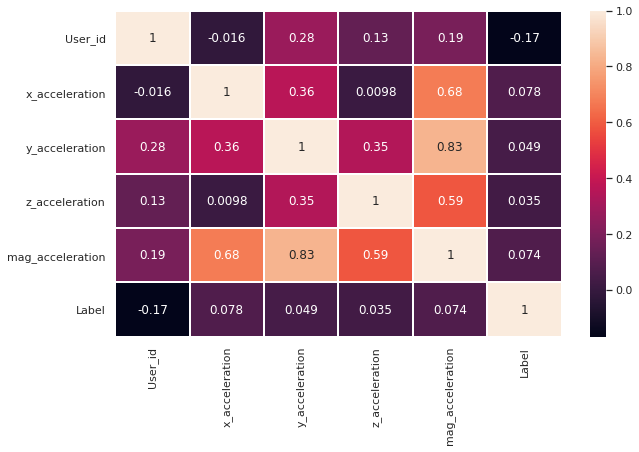

In [22]:
# checking the corelation between the features
fig=plt.gcf()
fig.set_size_inches((10,6))
sns.heatmap(data.corr(),annot=True,linewidths=1);

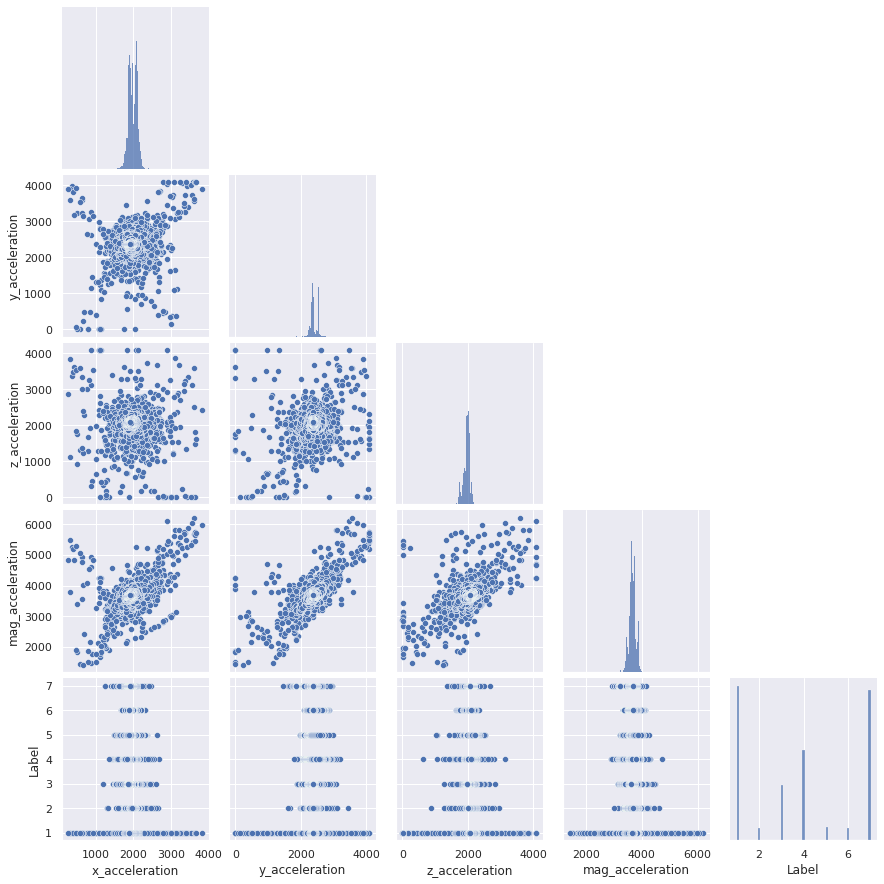

In [ ]:
# checking the co-relation between different features
sns.pairplot(data[["x_acceleration","y_acceleration","z_acceleration","mag_acceleration","Label"]],corner=True)
plt.show()

Conlusion:-

Here we can see that y_acceleration is more co-related with the magnitude of acceleration.

## 3.1- Anomaly Detection

On whole Data Set

In [ ]:
ev=EllipticEnvelope(contamination=0.1,random_state=42)

In [ ]:
predict_outliers=ev.fit_predict(data[["x_acceleration","y_acceleration","z_acceleration"]])

In [ ]:
print("Number of Outliers=",np.sum(predict_outliers==-1))
print("Percentage of Outliers=",str(round((np.sum(predict_outliers==-1)/len(data))*100,2))+"%")

Number of Outliers= 192318
Percentage of Outliers= 10.0%


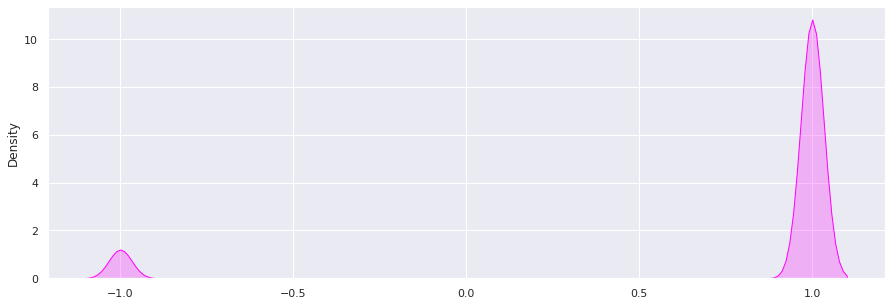

In [ ]:
fig=plt.gcf()
fig.set_size_inches((15,5))
sns.kdeplot(predict_outliers,shade=True,color="magenta")
plt.show()

## 3.2- Exploring each feature



### 3.2.1- x_acceleration

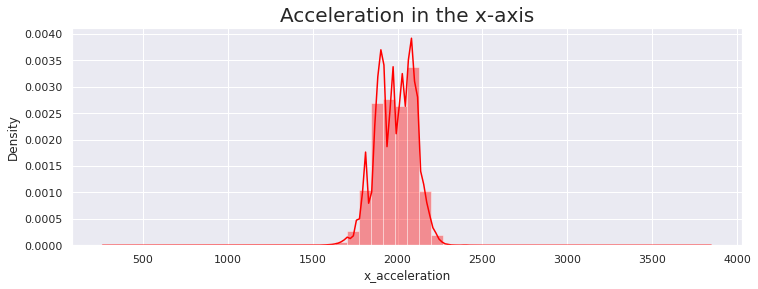

In [ ]:
fig=plt.gcf()
fig.set_size_inches((12,4))
sns.distplot(data.x_acceleration,color="red")
plt.title('Acceleration in the x-axis',fontsize=20);

Conclusion:

 Most(~50%) of the x_acceleration lies in between 1750 and 2250

####3.2.1.1- Anomaly Detection

In [ ]:
# Number of outliers in x_acceleration
print("Number of outliers=",len(data[(zscore(data.x_acceleration)<-3) | (zscore(data.x_acceleration)>3)]))
print("Percentage of Outliers=", str(round((len(data[(zscore(data.x_acceleration)<-3) | (zscore(data.x_acceleration)>3)])/len(data))*100,2))+"%")

Number of outliers= 4620
Percentage of Outliers= 0.24%


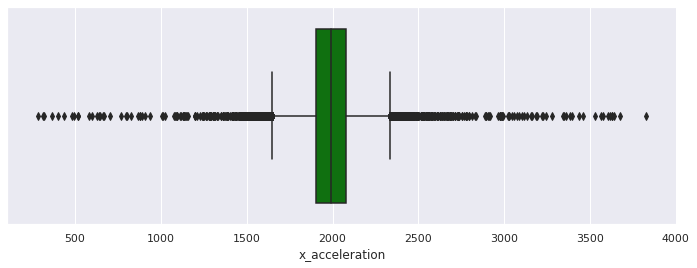

In [ ]:
# here the dots are showing the outliers location
fig=plt.gcf()
fig.set_size_inches((12,4))
sns.boxplot(data.x_acceleration,color="green",fliersize=5);

### 3.2.2- y_acceleration

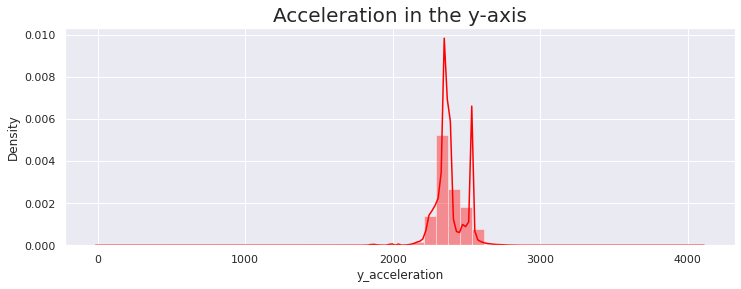

In [ ]:
fig=plt.gcf()
fig.set_size_inches((12,4))
sns.distplot(data.y_acceleration,color="red")
plt.title('Acceleration in the y-axis',fontsize=20);

Conclusion:

Most(~50%) of the y_acceleration lies in between 2250 and 2600

####3.2.2.1- Anomaly Detection

In [ ]:
# Number of outliers in y_acceleration
print("Number of outliers=",len(data[(zscore(data.y_acceleration)<-3) | (zscore(data.y_acceleration)>3)]))
print("Percentage of Outliers=", str(round((len(data[(zscore(data.y_acceleration)<-3) | (zscore(data.y_acceleration)>3)])/len(data))*100,2))+"%")

Number of outliers= 19685
Percentage of Outliers= 1.02%


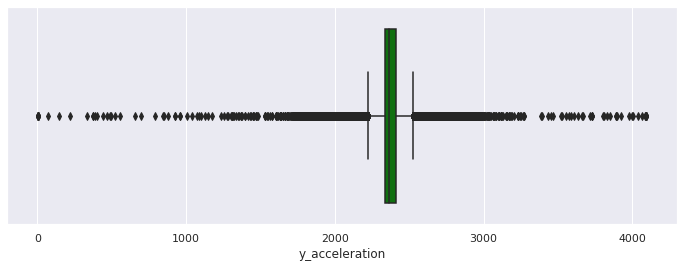

In [ ]:
# here the dots are showing the outliers location
fig=plt.gcf()
fig.set_size_inches((12,4))
sns.boxplot(data.y_acceleration,color="green",fliersize=5);

### 3.2.3- z_acceleration

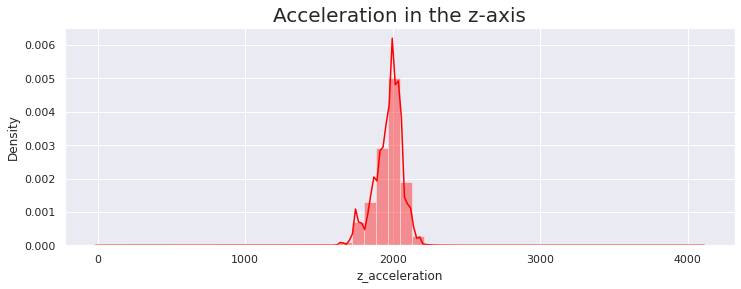

In [ ]:
fig=plt.gcf()
fig.set_size_inches((12,4))
sns.distplot(data.z_acceleration,color="red")
plt.title('Acceleration in the z-axis',fontsize=20);

Conclusion:

Most(~50%) of the z_acceleration lies in between 1800 and 2200

####3.2.3.1- Anomaly Detection

In [ ]:
# Number of outliers in z_acceleration
print("Number of outliers=",len(data[(zscore(data.z_acceleration)<-3) | (zscore(data.z_acceleration)>3)]))
print("Percentage of Outliers=", str(round((len(data[(zscore(data.z_acceleration)<-3) | (zscore(data.z_acceleration)>3)])/len(data))*100,2))+"%")

Number of outliers= 9286
Percentage of Outliers= 0.48%


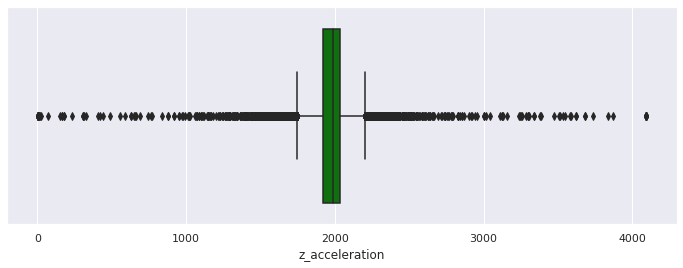

In [ ]:
# here the dots are showing the outliers location
fig=plt.gcf()
fig.set_size_inches((12,4))
sns.boxplot(data.z_acceleration,color="green",fliersize=5);

### 3.2.4- User_id

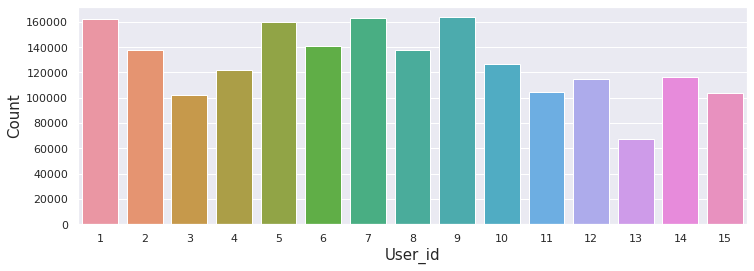

In [ ]:
fig=plt.gcf()
fig.set_size_inches((12,4))
sns.countplot("User_id",data=data)
plt.xlabel("User_id",fontsize=15)
plt.ylabel("Count",fontsize=15)
plt.show()

Conclusion:

Maximum amount of data is available from the Users 1,5,7,9 which is around 160000 data entries.
Minimum amount of data is available from the User 13.

In [ ]:
data.User_id.value_counts()

9     163740
7     163000
1     162500
5     160000
6     140670
8     137795
2     137731
10    126800
4     122200
14    116100
12    114701
11    104450
15    103500
3     102340
13     67650
Name: User_id, dtype: int64

### 3.2.5- Label

In [ ]:
label_counts=data.Label.value_counts(normalize=True)
label_counts

1    0.316490
7    0.308637
4    0.185664
3    0.112697
5    0.026778
2    0.024895
6    0.024839
Name: Label, dtype: float64

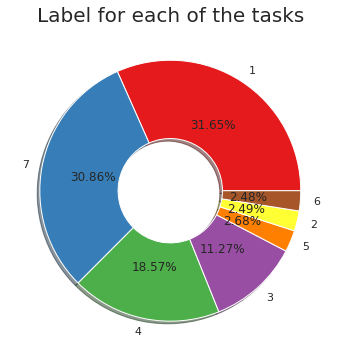

In [ ]:
fig=plt.gcf()
fig.set_size_inches((10,6))
cmap=plt.get_cmap("Set1")
color=cmap(np.arange(len(label_counts)))
plt.pie(label_counts,labels=label_counts.index,wedgeprops=dict(width=0.6),autopct="%.2f%%",colors=color,shadow=True,labeldistance=1.1);
plt.title('Label for each of the tasks',fontsize=20)
plt.show()

Conclusion:

People have spent most of the time on task 1 i.e. Working at Computer and the least time on task 6 i.e. Walking and Talking with Someone.
Task 2,6,5 are the least performed actions, which is around 2.5%
Task 1,7 are the most performed actions, which is around 30%.

## 3.3- Exploring the relationship between participants and their activities



In [ ]:
user_task_df=pd.crosstab(data.User_id,data.Label)
user_task_df

Label,1,2,3,4,5,6,7
User_id,,,,,,,
1,33677,928,11179,26860,3191,2917,83748
2,44150,3490,23475,22175,3910,7100,33431
3,41675,5475,4293,25900,2657,1400,20940
4,31540,4810,21405,23300,3745,1910,35490
5,30980,5370,13420,26750,3000,2880,77600
6,44040,3460,23495,22040,3935,6989,36711
7,32750,3600,10519,26770,2960,2700,83701
8,44040,3485,24605,22035,3900,5980,33750
9,36090,320,11330,26730,3115,2495,83660


In [ ]:
# Here 
## Blue Color ----> Maximum
## Red Color  ----> Minimum
user_task_df.style.highlight_max(axis=1,color="blue").highlight_min(axis=1,color="red")

Label,1,2,3,4,5,6,7
User_id,,,,,,,
1,33677,928,11179,26860,3191,2917,83748
2,44150,3490,23475,22175,3910,7100,33431
3,41675,5475,4293,25900,2657,1400,20940
4,31540,4810,21405,23300,3745,1910,35490
5,30980,5370,13420,26750,3000,2880,77600
6,44040,3460,23495,22040,3935,6989,36711
7,32750,3600,10519,26770,2960,2700,83701
8,44040,3485,24605,22035,3900,5980,33750
9,36090,320,11330,26730,3115,2495,83660


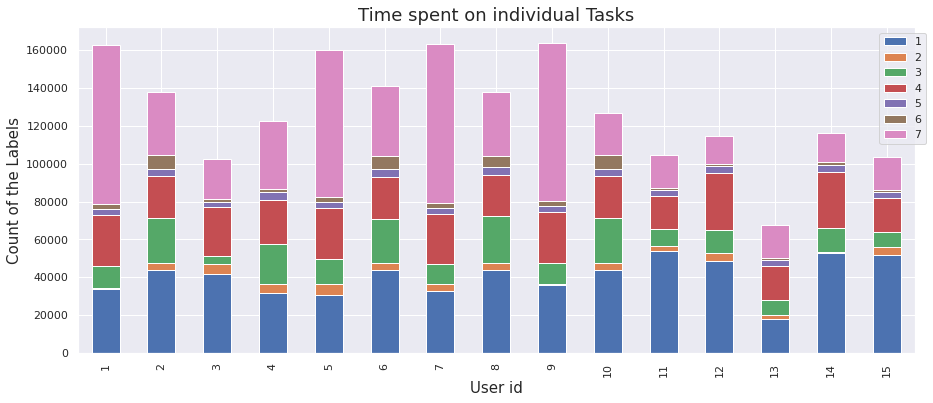

In [ ]:
user_task_df.plot(kind="bar",stacked=True,figsize=(15,6))
plt.legend(bbox_to_anchor=(1.02,1))
plt.title('Time spent on individual Tasks',fontsize=18)
plt.xlabel('User id',fontsize=15)
plt.ylabel('Count of the Labels',fontsize=15)
plt.show()

Insight - 1 :

Time spent by each individual on task 1 (Working at Computer) is the maximum.

In [ ]:
max_dict,min_dict={},{}
for i,value in enumerate(data.Label.unique()):
    max_dict[i]=data.x_acceleration[data.Label==value].max()
    min_dict[i]=data.x_acceleration[data.Label==value].min()

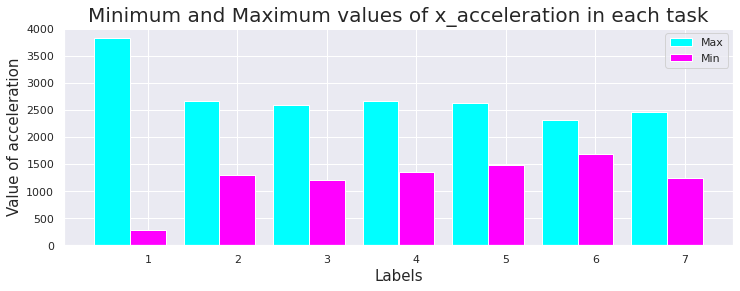

In [ ]:
fig=plt.gcf()
fig.set_size_inches((12,4))
plt.bar(np.arange(len(max_dict))-0.4,max_dict.values(),width=0.4,color="cyan",label="Max")
plt.bar(np.arange(len(min_dict)),min_dict.values(),width=0.4,color="magenta",label="Min")
plt.legend()
plt.title("Minimum and Maximum values of x_acceleration in each task",fontsize=20)
plt.xlabel("Labels",fontsize=15)
plt.ylabel("Value of acceleration",fontsize=15)
plt.xticks(np.arange(len(max_dict)),[str(i) for i in range(1,8)])
plt.show()

Insight- 2:

Both Minimum & Maximum values of acceleration in X-axis is in task-1

In [ ]:
max_dict,min_dict={},{}
for i,value in enumerate(data.Label.unique()):
    max_dict[i]=data.y_acceleration[data.Label==value].max()
    min_dict[i]=data.y_acceleration[data.Label==value].min()

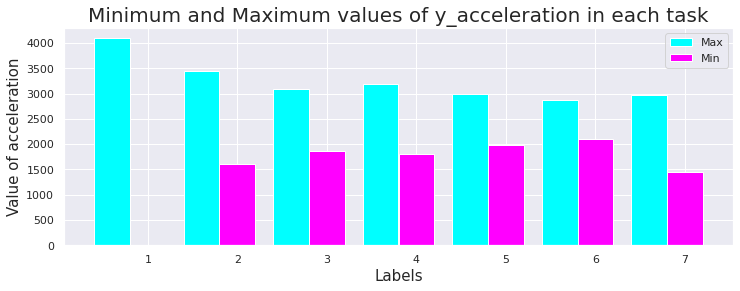

In [ ]:
fig=plt.gcf()
fig.set_size_inches((12,4))
plt.bar(np.arange(len(max_dict))-0.4,max_dict.values(),width=0.4,color="cyan",label="Max")
plt.bar(np.arange(len(min_dict)),min_dict.values(),width=0.4,color="magenta",label="Min")
plt.legend()
plt.title("Minimum and Maximum values of y_acceleration in each task",fontsize=20)
plt.xlabel("Labels",fontsize=15)
plt.ylabel("Value of acceleration",fontsize=15)
plt.xticks(np.arange(len(max_dict)),[str(i) for i in range(1,8)])
plt.show()

Insight- 3:

Both Minimum & Maximum values of acceleration in Y-axis is in task-1

In [ ]:
max_dict,min_dict={},{}
for i,value in enumerate(data.Label.unique()):
    max_dict[i]=data.z_acceleration[data.Label==value].max()
    min_dict[i]=data.z_acceleration[data.Label==value].min()

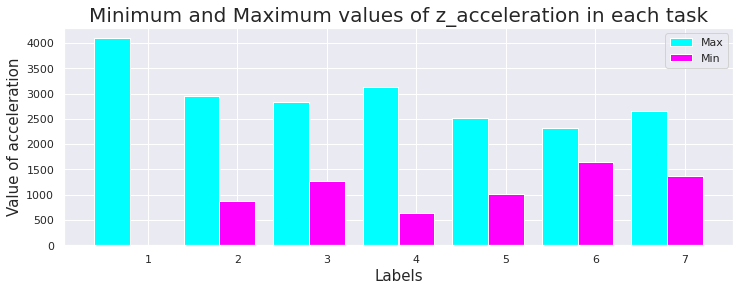

In [ ]:
fig=plt.gcf()
fig.set_size_inches((12,4))
plt.bar(np.arange(len(max_dict))-0.4,max_dict.values(),width=0.4,color="cyan",label="Max")
plt.bar(np.arange(len(min_dict)),min_dict.values(),width=0.4,color="magenta",label="Min")
plt.legend()
plt.title("Minimum and Maximum values of z_acceleration in each task",fontsize=20)
plt.xlabel("Labels",fontsize=15)
plt.ylabel("Value of acceleration",fontsize=15)
plt.xticks(np.arange(len(max_dict)),[str(i) for i in range(1,8)])
plt.show()

Insight- 4:

Both Minimum & Maximum values of acceleration in Z-axis is in task-1

User_id 1
The acceleration in x,y,z axis and the Labels


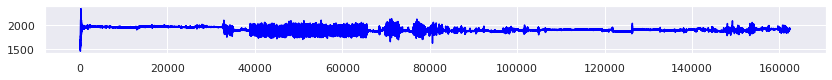

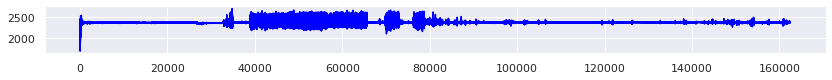

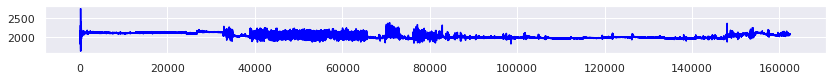

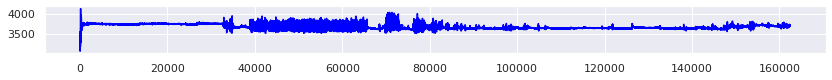

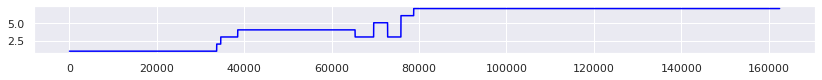

End of 1 plot

User_id 2
The acceleration in x,y,z axis and the Labels


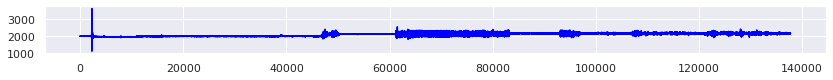

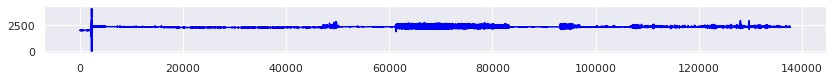

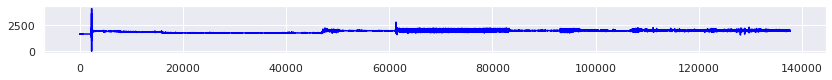

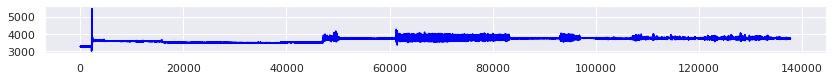

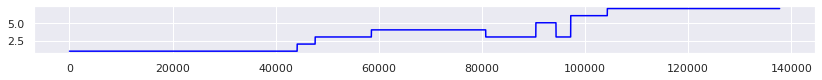

End of 2 plot

User_id 3
The acceleration in x,y,z axis and the Labels


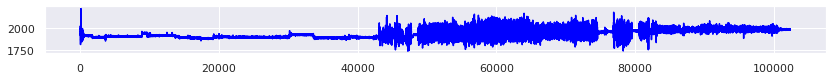

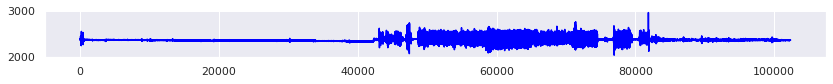

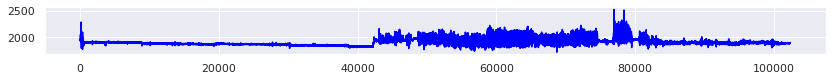

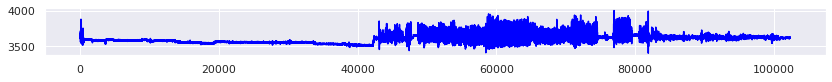

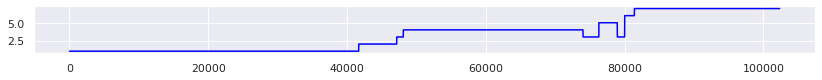

End of 3 plot

User_id 4
The acceleration in x,y,z axis and the Labels


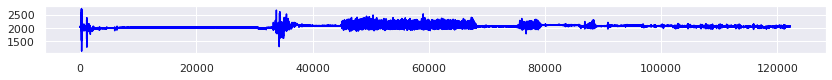

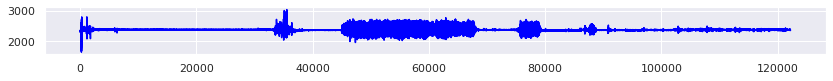

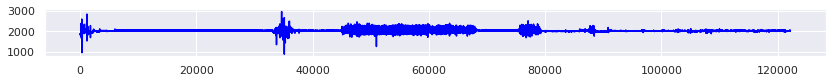

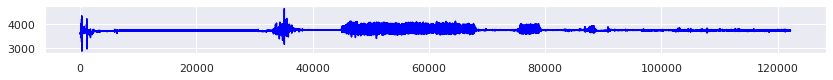

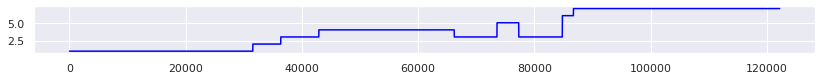

End of 4 plot

User_id 5
The acceleration in x,y,z axis and the Labels


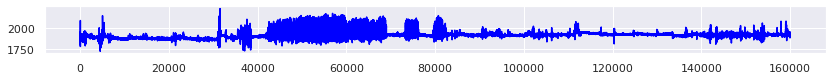

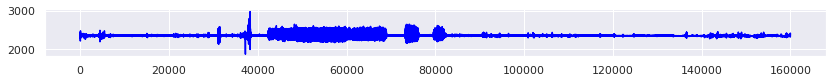

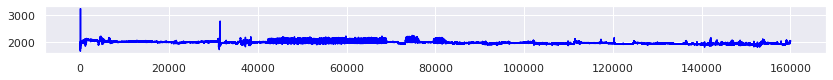

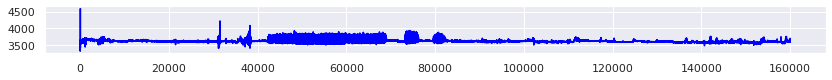

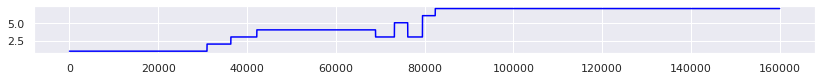

End of 5 plot

User_id 6
The acceleration in x,y,z axis and the Labels


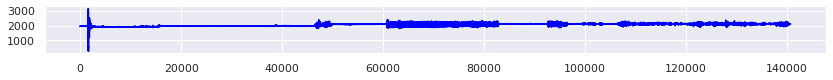

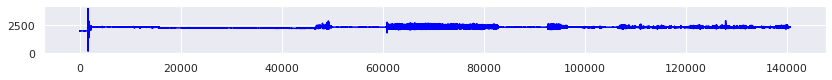

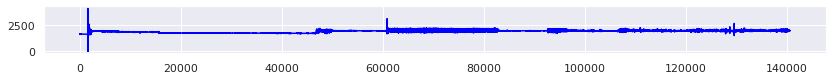

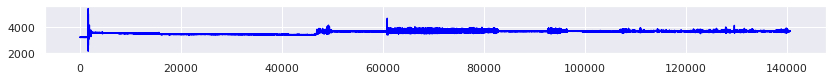

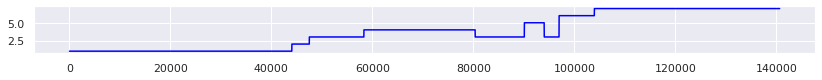

End of 6 plot

User_id 7
The acceleration in x,y,z axis and the Labels


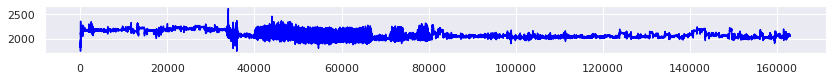

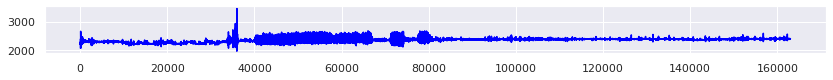

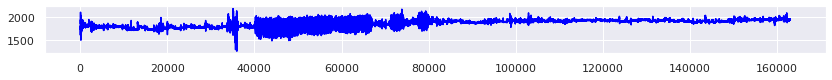

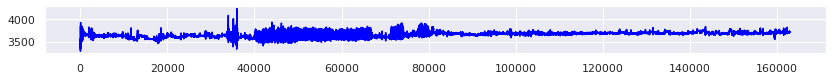

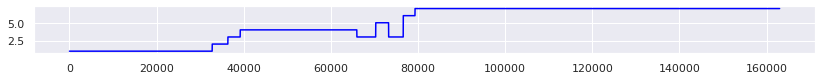

End of 7 plot

User_id 8
The acceleration in x,y,z axis and the Labels


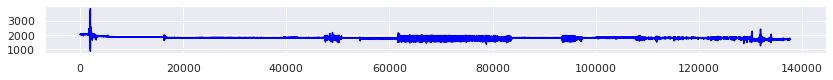

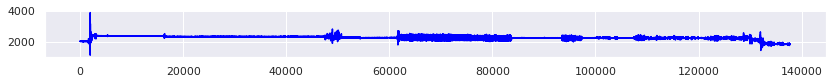

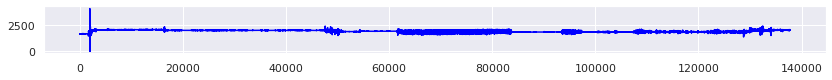

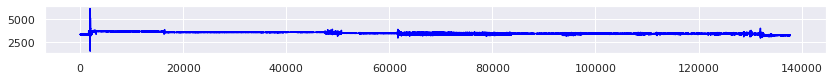

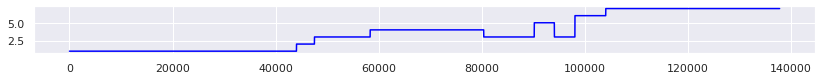

End of 8 plot

User_id 9
The acceleration in x,y,z axis and the Labels


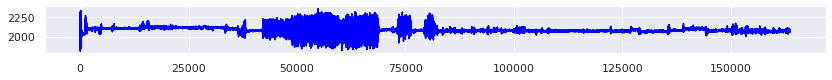

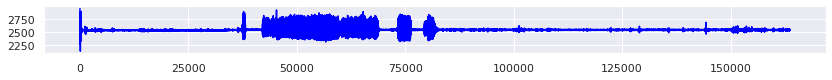

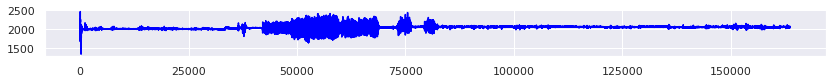

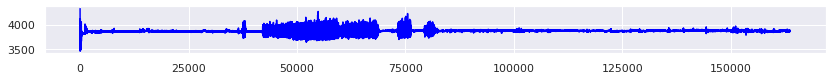

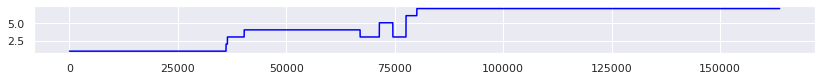

End of 9 plot

User_id 10
The acceleration in x,y,z axis and the Labels


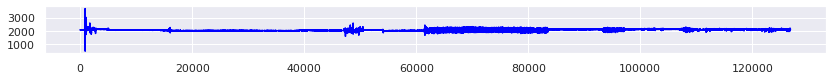

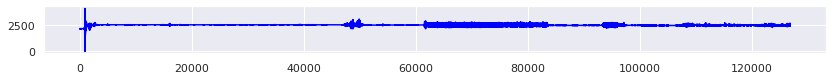

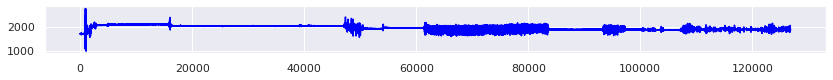

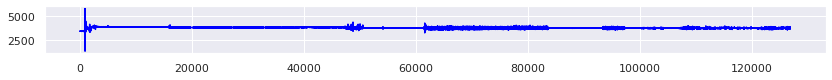

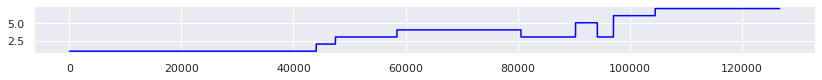

End of 10 plot

User_id 11
The acceleration in x,y,z axis and the Labels


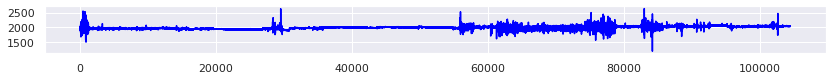

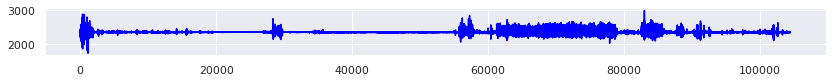

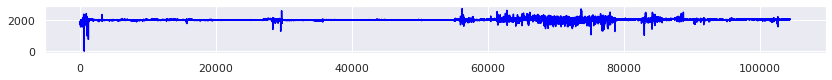

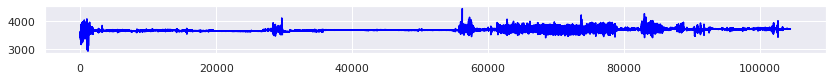

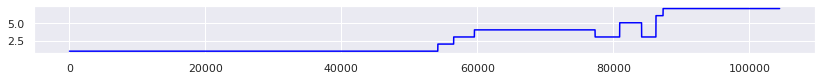

End of 11 plot

User_id 12
The acceleration in x,y,z axis and the Labels


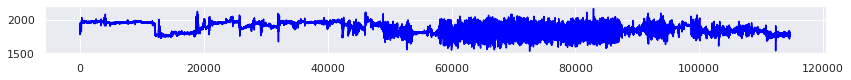

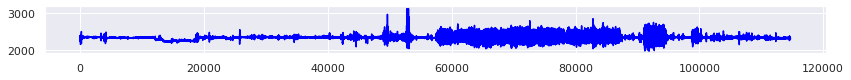

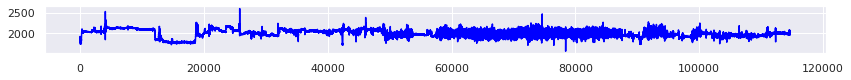

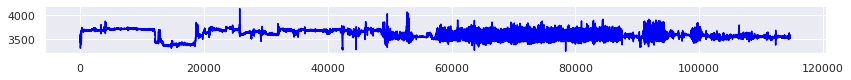

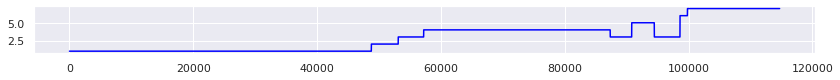

End of 12 plot

User_id 13
The acceleration in x,y,z axis and the Labels


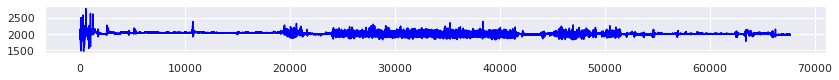

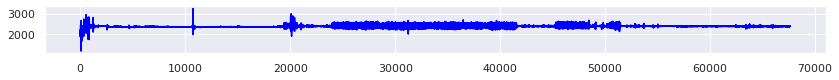

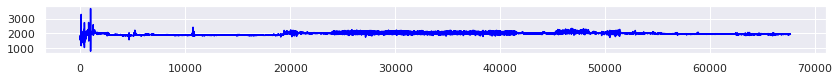

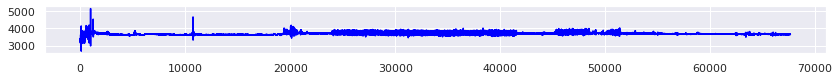

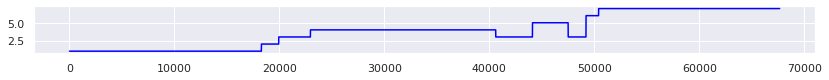

End of 13 plot

User_id 14
The acceleration in x,y,z axis and the Labels


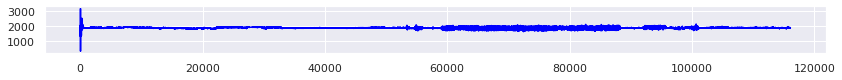

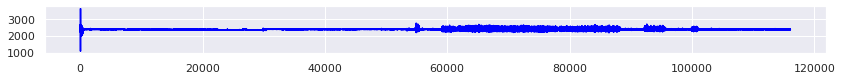

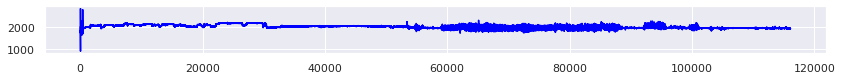

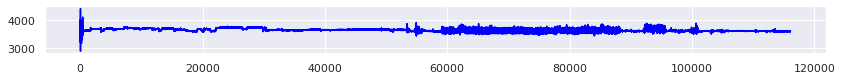

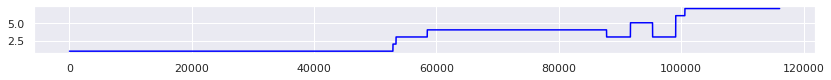

End of 14 plot

User_id 15
The acceleration in x,y,z axis and the Labels


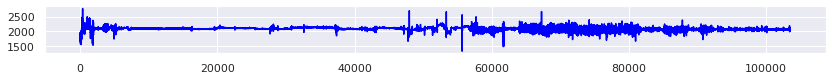

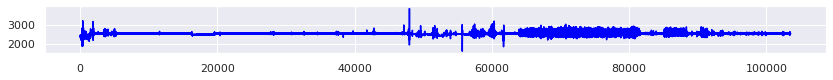

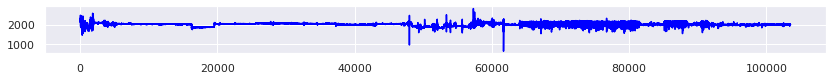

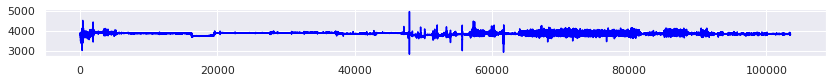

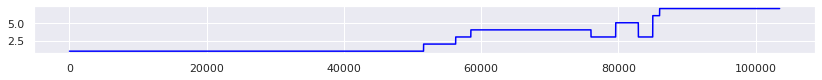

End of 15 plot



In [ ]:
def user_axis_acceleration_plot(user):
    for i in range(user.shape[1]):
        plt.figure(figsize=(14,5))
        plt.subplot(user.shape[1],1,i+1)
        plt.plot(user[:,i],color='blue')
        plt.show()
for i in sorted(list(data.User_id.unique())):
    print('User_id',i)
    print('The acceleration in x,y,z axis and the Labels')
    user_axis_acceleration_plot(data[data.User_id==i].iloc[:,1:].values)
    print('End of',i,'plot\n')

Insight- 5:

The labels are dependent on all x,y,z axis acceleration.

# 4- Data Modelling

## 4.1 - Data Spliting

In [23]:
x=data.iloc[:,:-1]
y=data.iloc[:,-1:]

In [24]:
train_x,test_x,train_y,test_y=train_test_split(x,y,test_size=0.2,random_state=42)

In [25]:
len(train_x)

1538541

In [26]:
len(test_x)

384636

## 4.2 - Feature Scaling

In [27]:
sc=StandardScaler()
train_x=sc.fit_transform(train_x)
test_x=sc.transform(test_x)

## 4.3 - Building Pipeline

In [28]:
# finding the optimal value of k
non_optimal_y=[]
for i in range(1,15):
    knn=KNeighborsClassifier(n_neighbors=i,p=2)
    knn.fit(train_x,train_y)
    optimal_y=knn.predict(test_x)
    optimal_y=optimal_y.reshape(len(optimal_y),1)
    non_optimal_y.append(np.mean(optimal_y!=test_y))

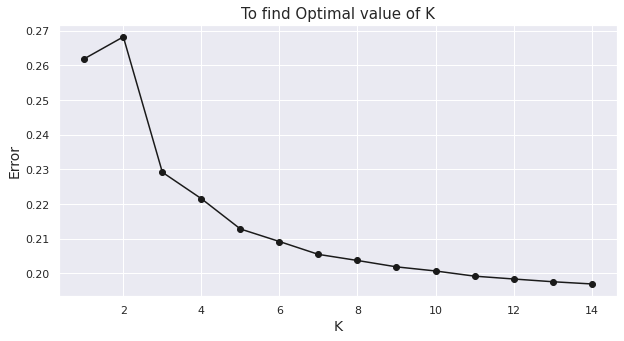

In [29]:
# using Elbow Method in order to find the optimal value of k
fig=plt.gcf()
fig.set_size_inches((10,5))
sns.set(style="darkgrid")
plt.plot(range(1,len(non_optimal_y)+1),non_optimal_y,"-ok")
plt.title("To find Optimal value of K",fontsize=15)
plt.xlabel("K",fontsize=14)
plt.ylabel("Error",fontsize=14)
plt.show()

From the elbow method the value of K is choosen, The accuracy remains the same(approximately) for the value of K from range (8 to 15), hence 8 is choosen as the optimal value.

In [31]:
# pipeline having various models in it
model_pipeline=[
    ("knn",KNeighborsClassifier(n_neighbors=8,p=2,n_jobs=-1)),
    ("decision_tree",DecisionTreeClassifier(criterion="entropy",random_state=42)),
    ("random_forest",RandomForestClassifier(n_estimators=70,random_state=42,n_jobs=-1))
]

In [32]:
estimators={}
for model_name , model in model_pipeline:
    estimator_metrics,d=[],{}
    print(f"Showing results for {model_name} classifier :- ")
    model.fit(train_x,train_y)
    estimator_metrics.append(model)

    pred_train_y=model.predict(train_x)
    d["pred_train_y"]=pred_train_y
    
    pred_test_y=model.predict(test_x)
    d["pred_test_y"]=pred_test_y
    
    print("For Training Set :-")
    print(f"Accuracy_Score = {metrics.accuracy_score(train_y,pred_train_y)}")
    d["Accuracy_Score_train"]=metrics.accuracy_score(train_y,pred_train_y)
    
    print("For Testing Set :-")
    print(f"Accuracy_Score = {metrics.accuracy_score(test_y,pred_test_y)}\n")
    d["Accuracy_Score_test"]=metrics.accuracy_score(test_y,pred_test_y)
    
    estimator_metrics.append(d)
    estimators[model_name]=estimator_metrics

Showing results for knn classifier :- 
For Training Set :-
Accuracy_Score = 0.8284004131186624
For Testing Set :-
Accuracy_Score = 0.7963477157624351

Showing results for decision_tree classifier :- 
For Training Set :-
Accuracy_Score = 0.9699865001972648
For Testing Set :-
Accuracy_Score = 0.7362571366174773

Showing results for random_forest classifier :- 
For Training Set :-
Accuracy_Score = 0.9698864053671628
For Testing Set :-
Accuracy_Score = 0.7884337399515386



In [33]:
# Confusion matrix for all models
models_confusion_matrix=[]
for model_name , model in estimators.items():
    models_confusion_matrix.append(metrics.confusion_matrix(test_y,model[1]["pred_test_y"]))
    
#The values are normalised in order to plot the confusion matrix
knn_confusion_matrix=np.round((models_confusion_matrix[0]/models_confusion_matrix[0].sum(axis=1)),4)
decision_tree_confusion_matrix=np.round((models_confusion_matrix[1]/models_confusion_matrix[1].sum(axis=1)),4)
random_forest_confusion_matrix=np.round((models_confusion_matrix[2]/models_confusion_matrix[2].sum(axis=1)),4)

KNN confusion matrix

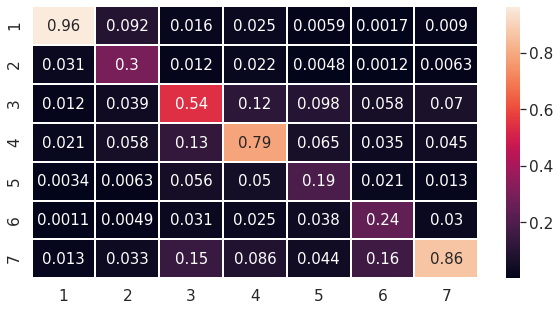

In [34]:
fig=plt.gcf()
fig.set_size_inches((10,5))
sns.set(font_scale=1.4)
plots=sns.heatmap(knn_confusion_matrix,annot=True,linewidths=1,annot_kws={"size": 15})
plots.set(xticklabels=[1,2,3,4,5,6,7])
plots.set(yticklabels=[1,2,3,4,5,6,7])
plt.show()

Decision-Tree confusion matrix

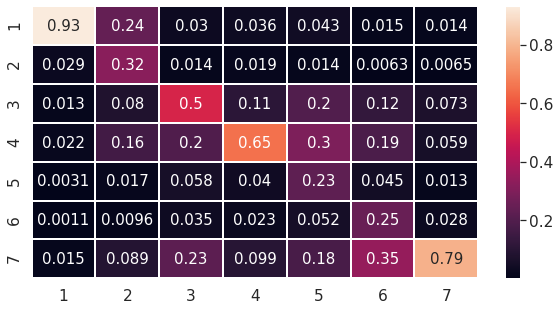

In [35]:
fig=plt.gcf()
fig.set_size_inches((10,5))
sns.set(font_scale=1.4)
plots=sns.heatmap(decision_tree_confusion_matrix,annot=True,linewidths=1,annot_kws={"size": 15})
plots.set(xticklabels=[1,2,3,4,5,6,7])
plots.set(yticklabels=[1,2,3,4,5,6,7])
plt.show()

Random-Forest confusion matrix

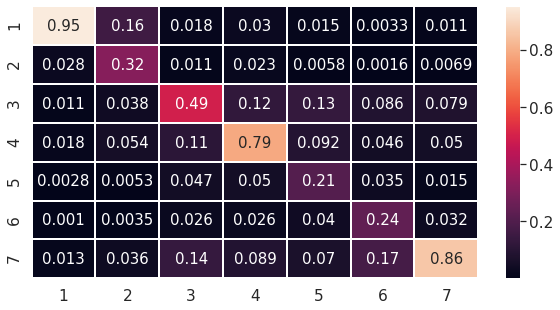

In [36]:
fig=plt.gcf()
fig.set_size_inches((10,5))
sns.set(font_scale=1.4)
plots=sns.heatmap(random_forest_confusion_matrix,annot=True,linewidths=1,annot_kws={"size": 15})
plots.set(xticklabels=[1,2,3,4,5,6,7])
plots.set(yticklabels=[1,2,3,4,5,6,7])
plt.show()

## 4.4 - Cross- Validation

In [37]:
for model_name , model in estimators.items():
    print(f"Cross Validation Score of {model_name} :-")
    scores=cross_validate(model[0],train_x,train_y,scoring="accuracy",cv=5)
    print("Score=",scores["test_score"].mean())
    print("\n")

Cross Validation Score of knn :-
Score= 0.7963102705636192


Cross Validation Score of decision_tree :-
Score= 0.734925490940361


Cross Validation Score of random_forest :-
Score= 0.7887563606060296




From K-Fold Cross validation, KNN is performing better in the training set as it is showing less variance in the accuracy score.

## 4.5 - Comparison between KNN , Decision tree and Random Forest Classifier

In [38]:
KNN_score=[estimators["knn"][1]["Accuracy_Score_train"],estimators["knn"][1]["Accuracy_Score_test"]]
decision_score=[estimators["decision_tree"][1]["Accuracy_Score_train"],estimators["decision_tree"][1]["Accuracy_Score_test"]]
random_score=[estimators["random_forest"][1]["Accuracy_Score_train"],estimators["random_forest"][1]["Accuracy_Score_test"]]

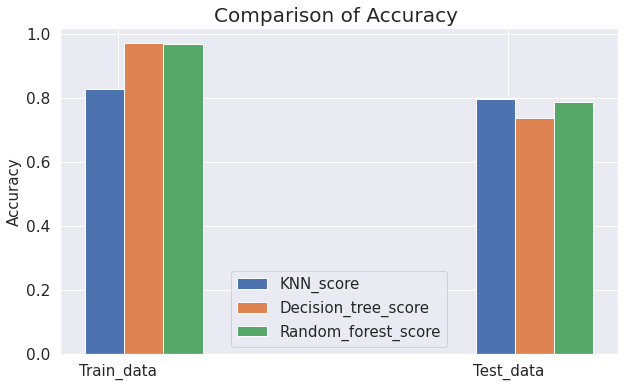

In [39]:
ind = np.arange(2) 
width = 0.1
plt.figure(figsize=(10,6))
plt.bar(ind, KNN_score, width, label='KNN_score')
plt.bar(ind + width, decision_score, width, label='Decision_tree_score')
plt.bar(ind + width + width, random_score, width, label='Random_forest_score')

plt.ylabel('Accuracy',fontsize=15)
plt.title('Comparison of Accuracy ',fontsize=20)

plt.xticks(ind + width / 3, ('Train_data','Test_data'),fontsize=15)
plt.legend(fontsize=15)
plt.show()

# 5- Final Model Selection

## Recommendation: K-Nearest Neighbours is a better classifier on the Accelerometer dataset

1- Accuracy of KNN Classifier is 79.63%, Decision tree Classifier is 73.62% and Random Forest Classifier is 78.84% on the Test data.

2- Accuracy from the KNN Classifier is slightly higher than that of Random Forest but much higher than the Decision tree.

3- The computational complexity for KNN is comparatively more as it doesn't built a generalised model during the training phase hence it requires more time in testing phase, also we can say that it computes distances of each query instance to all training samples but as KNN performs instance-based learning, a well-tuned K can model complex decision spaces having arbitrarily complicated decision boundarie which are not modeled by other 'eager' Classifiers like Decision tree.

4- KNN naturally supports incremental learning.

5- Random Forest overfitts the model as it is showing less bias and high variance, thus making it less compatible for this data.
But KNN is showing less bias and less variance as compared to other Classifiers.

6- KNN classifier gives test error rates closer to that of Bayesian classier (the gold standard)

7- KNN classifier works better in large number of samples like this data.